In [1]:
%matplotlib inline

# Building a simple neural-network with Keras

Written by **Xavier Snelgrove** ([link to his GitHub](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb)), with minor modifications from **Rafael Padilha**.

This is a simple tutorial on working with neural networks in Keras. In this exercise, we will define, train and evaluate a simple feed-forward NN to classify handwritten digits.


## Imports
First let's import some prerequisites:

In [2]:
import numpy as np
from random import shuffle, seed
seed(42)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras import optimizers

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Load training data

In [3]:
nb_classes = 10

# the data, shuffled and split between trainVal and test sets
(trainVal_data, trainVal_label), (X_test, y_test) = mnist.load_data()

# We want now to split the trainVal data into train and validation sets
nData = trainVal_data.shape[0]  #find the size of trainVal
nTrain = int(nData * 0.8)  #80% to train, 20% to val

randomIdx = list(range(nData))   #randomly select indexes
shuffle(randomIdx)
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

# Split the data
X_val, y_val = trainVal_data[valIdx], trainVal_label[valIdx]
X_train, y_train = trainVal_data[trainIdx], trainVal_label[trainIdx]

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape), "\n"

print("X_val original shape", X_val.shape)
print("y_val original shape", y_val.shape), "\n"

print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

X_train original shape (48000, 28, 28)
y_train original shape (48000,)
X_val original shape (12000, 28, 28)
y_val original shape (12000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)


Let's look at some examples of the training data:

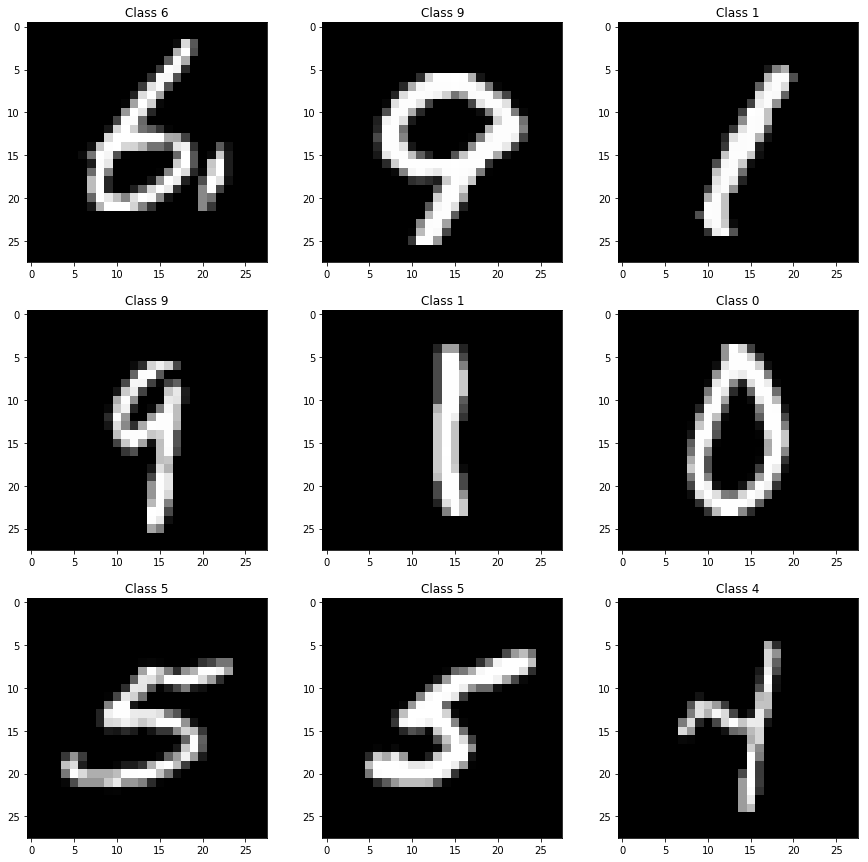

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## How balanced is our training?
Let's check how many examples we have for each class and calculate a class weight. This can be useful to tell the model to "pay more attention" during training to samples from an under-represented class.

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
print ("Train ---> ", dict(zip(unique, counts)), "\n")


from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
train_class_weights = dict(enumerate(class_weights))
print (train_class_weights, "\n")

Train --->  {0: 4724, 1: 5393, 2: 4723, 3: 4881, 4: 4704, 5: 4313, 6: 4769, 7: 5001, 8: 4730, 9: 4762} 

{0: 1.0160880609652836, 1: 0.8900426478768775, 2: 1.0163031971204743, 3: 0.9834050399508297, 4: 1.0204081632653061, 5: 1.1129144447020636, 6: 1.0065003145313483, 7: 0.9598080383923215, 8: 1.014799154334038, 9: 1.0079798404031919} 



In [6]:
#For the test set ---> We will use this to find the normalized accuracy
unique, counts = np.unique(y_test, return_counts=True)
print("Test ---> ", dict(zip(unique, counts)), "\n")

test_sample_per_class = counts

Test --->  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009} 



## Format the data for training
Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. We'll also scale the inputs to be in the range [0-1] rather than [0-255]

In [7]:
X_train = X_train.reshape(48000, 784)
X_val = X_val.reshape(12000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (48000, 784)
Validation matrix shape (12000, 784)
Testing matrix shape (10000, 784)


Let's also modify the target matrices to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
...
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 1]
```

Keras already has a method to do this, `np_utils.to_categorical`:

In [8]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Build the neural network
Build the neural-network. Here we'll do a simple neural network with 4 layers (input + 2 hidden layers + output), using fully connected layers. In this type of layer, each neuron is connected to every input units. If we consider the first hidden layer, each of its neurons is connected to each pixel in the input image.
<img src="figure.png" />

In [9]:
# The Sequential model is a linear stack of layers.
model = Sequential()

model.add(Dense(512, input_shape=(784,), activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))

# And connect it with the output layer, which has neurons equal to the number of classes
#in our problem (10 neurons as it will predict one-hot vectors of size 10)
model.add(Dense(10))

# Finally, we will use the softmax activation
model.add(Activation('softmax')) # "softmax", among other things, ensures the output 
                                 # is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.

## Compile the model
Keras is built on top of TensorFlow or Theano, both packages that allow you to define a *computation graph* in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function**, your **optimizer** and some **metrics**. The loss function we'll use here is called *categorical crossentropy*, and is a loss function well-suited to comparing two probability distributions.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The [optimizer](https://keras.io/optimizers) helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". In this exercise we will use a variation of the Gradient Descent, called **Stocastic Gradient Descent (SGD)**. Instead of considering the whole training data at each iteration of the optimization, SGD only uses a batch sampled from the available training data at a time.

Besides that, we can define a number of metrics (such as accuracy, mean squared error, mean absolute error etc) to follow during training. **However, by default Keras does not output the normalized accuracy!**

In [10]:
sgd = optimizers.SGD(lr=0.01) #lr = learning rate
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

## Train the model!
This is the fun part: you can feed the training data loaded in earlier into this model and it will learn to classify digits. 

But first, let's understand what are these arguments:
- **X_train & Y_train:** the training data and labels;
- **batch_size:** instead of optimizing your network on all training data, we usually optimize it over batches (small samples from the training data). In this case, we will update our weights (backpropagation) after forwarding/processing 128 images;
- **nb_epoch:** an epoch occurs when all your training data is processed/forwarded once. We are saying we will process our data 8 times;
- **verbose:** show loss after each epoch;
- **class_weight:** the weight of each class, considering they are not balanced. This will ponder the loss based on how frequent each class is;
- **validation_data:** after each epoch our model will predict these data and output the loss and accuracy.

In [11]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=50, verbose=1,
          class_weight = train_class_weights, 
          validation_data=(X_val, Y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 4s 88us/step - loss: 2.2744 - acc: 0.1788 - val_loss: 2.2441 - val_acc: 0.2949
Epoch 2/50
48000/48000 [==============================] - 4s 81us/step - loss: 2.2136 - acc: 0.3876 - val_loss: 2.1774 - val_acc: 0.5602
Epoch 3/50
48000/48000 [==============================] - 4s 82us/step - loss: 2.1401 - acc: 0.5531 - val_loss: 2.0908 - val_acc: 0.6560
Epoch 4/50
48000/48000 [==============================] - 4s 86us/step - loss: 2.0430 - acc: 0.6335 - val_loss: 1.9793 - val_acc: 0.6675
Epoch 5/50
48000/48000 [==============================] - 4s 86us/step - loss: 1.9112 - acc: 0.6707 - val_loss: 1.8229 - val_acc: 0.7195
Epoch 6/50
48000/48000 [==============================] - 4s 86us/step - loss: 1.7409 - acc: 0.6986 - val_loss: 1.6348 - val_acc: 0.6948
Epoch 7/50
48000/48000 [==============================] - 4s 82us/step - loss: 1.5456 - acc: 0.7194 - val_loss: 1.4334 - val_acc

## Finally, evaluate its performance on the test data

In [12]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT NORMALIZED):', score[1])

10000/10000 [==============================] - 0s 47us/step
Test loss: 0.3352061598181725
Test accuracy (NOT NORMALIZED): 0.9044


## Normalized Accuracy

In [13]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

#Get the class for each one_hot array of our test samples
Y_test_classes = np.argmax(Y_test, axis=-1)

accPerClass = []
for classIdx in range(nb_classes):
    idx = (Y_test_classes == classIdx)
    
    correctPred = np.sum(predicted_classes[idx] == Y_test_classes[idx])
    accPerClass.append( correctPred / float(test_sample_per_class[classIdx]))
    
print (dict(zip(range(nb_classes),accPerClass)), "\n")
print ("Normalized Acc --> ", np.mean(accPerClass))

{0: 0.9734693877551021, 1: 0.9682819383259912, 2: 0.8624031007751938, 3: 0.8900990099009901, 4: 0.9266802443991853, 5: 0.844170403587444, 6: 0.9258872651356994, 7: 0.9036964980544747, 8: 0.8603696098562629, 9: 0.8771060455896927} 

Normalized Acc -->  0.9032163503380037


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [14]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

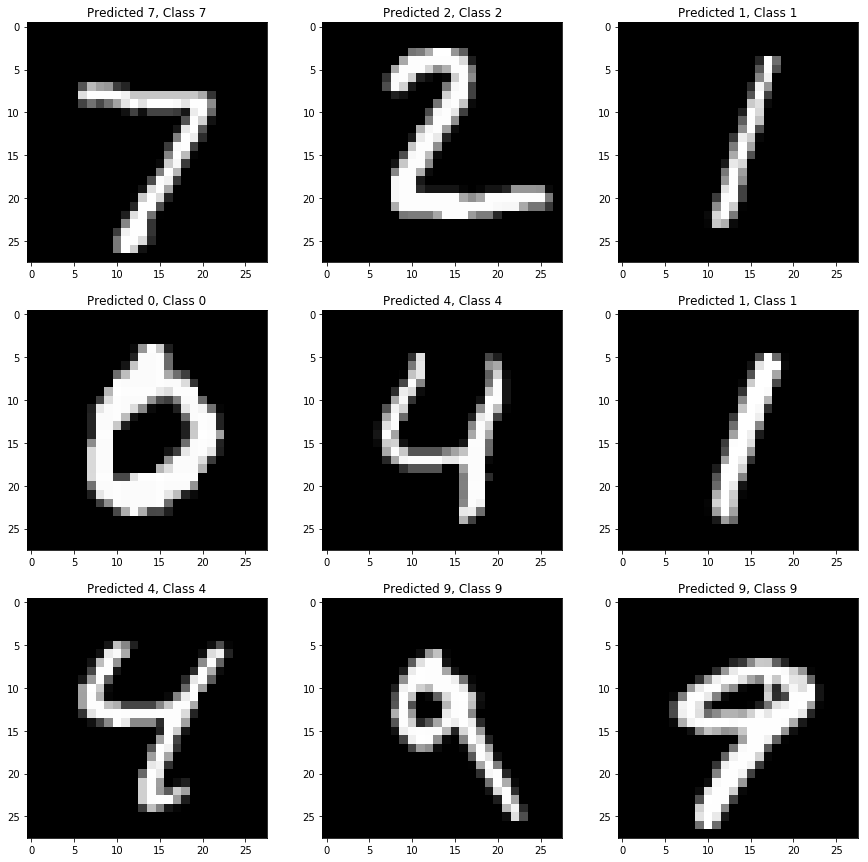

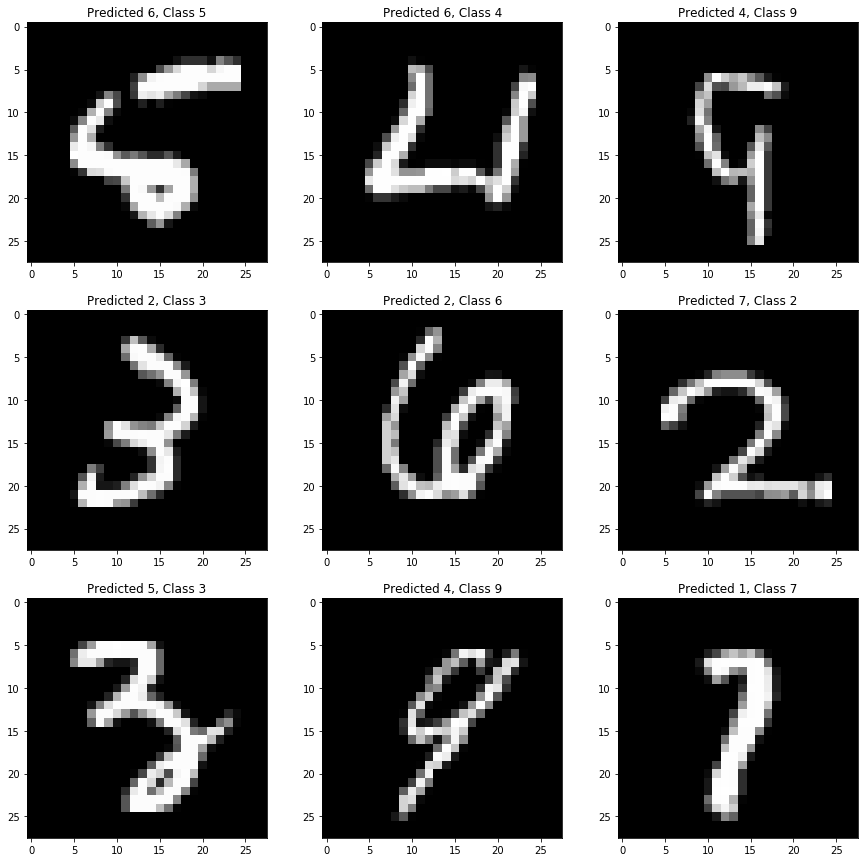

In [15]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

# References

There are lots of other great examples at the Keras homepage at http://keras.io and in the source code at https://github.com/fchollet/keras. Besides those, this notebook was adapted from [this](https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb).